# Logistic Regression

### Import libraries

In [1]:
import pandas as pd # one-hot encoding
import numpy as np
import glob
import os

import matplotlib.pyplot as plt # graphs
import matplotlib.colors as colors

import joblib
import datetime

from collections import defaultdict

import sklearn
from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV # cross validation
#from sklearn.preprocessing import scale # scale and center data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy

### Import data

In [2]:
corpus = pd.read_csv("../dataset/dataset.csv")
corpus.head()

,CONTENT,CLASS
0,"''Oh my god, do the people at the hospital kno...",0
1,1:19 Ross's face... I just can't 🤣🤣🤣🤣,0
2,love this LMAO,0
3,All the water they spill at him and there are ...,0
4,@WeNeedMoreGodsInT-Shirts Do you know the word...,0


### Statistics about the data

Data types:
CONTENT    object
CLASS       int64
dtype: object

There are 2 comment types: [0 1]
The dataset contains of 30575 examples: 12910 spam and 17665 legitimate comments


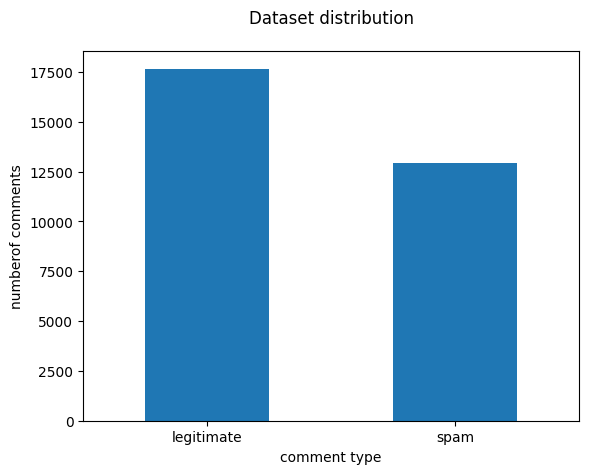

In [3]:
print(f"Data types:\n{corpus.dtypes}\n")
print(f"There are {len(corpus['CLASS'].unique())} comment types: {corpus['CLASS'].unique()}")
print(f"The dataset contains of {len(corpus)} examples: {len(corpus.loc[corpus['CLASS'] == 1])} spam and {len(corpus.loc[corpus['CLASS'] == 0])} legitimate comments")

corpus.groupby("CLASS").CONTENT.count().plot.bar(ylim=0)
plt.xticks([0,1],['legitimate', 'spam'], rotation=0)
plt.xlabel("comment type")
plt.ylabel("numberof comments")
plt.title("Dataset distribution", pad=20)
plt.show()

In [4]:
def preprocess_data(corpus):
    nlp = spacy.load("en_core_web_sm")

    # remove blank rows if any
    corpus.dropna(inplace=True)
    
    # add column for representation
    corpus['REPR'] = corpus.loc[:, 'CONTENT']
        
    # lower case
    corpus['REPR'] = corpus['REPR'].str.lower()
    
    for comment in corpus["REPR"]:    
        doc = nlp(comment)
        # lemmatize, remove stopwords
        comment = " ".join([token.lemma_ for token in doc if not token.is_stop])

In [5]:
preprocess_data(corpus)

# binary feature representation
vectorizer = CountVectorizer(binary=True, max_df=0.95) #max_features=10000, tokenizer=lambda doc: doc)
BOW = vectorizer.fit_transform(corpus["REPR"])

# count based feature representation
vectorizer_2 = CountVectorizer(binary=False, max_df=0.95) #max_features=10000)
BOW_2 = vectorizer_2.fit_transform(corpus["REPR"])

# bag of 2-Grams
bigram_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(2,2))
BOW_3 = bigram_vectorizer.fit_transform(corpus["REPR"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, use_idf=True, stop_words='english') #min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
tfidf_voc = tfidf_vectorizer.fit_transform(corpus["REPR"])

/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Logistic Regression model

### Train, store and evaluate

In [6]:

def split_data(features, labels):
    return train_test_split(features,labels, test_size=0.3,random_state=42,shuffle=True)


def save_model(model):
    now = datetime.datetime.now()
    model_output_path = "saved_models/"+model.__class__.__name__.lower()+"_"+str(now.minute)+"-"+str(now.second)+".joblib"
    joblib.dump(model, open(model_output_path, 'wb+'))


def report(model, best_model, X_test, y_test, labels):
    print(f"Best parameters set {model.best_params_} with accuracy {model.best_score_}")
    y_predict = best_model.predict(X_test)
    
    labels = sorted(list(set(labels)))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_predict, labels=labels) # lables=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    
    print("\nAccuracy: {}%".format(accuracy_score(y_test, y_predict)*100))
    print("Precision: {}%".format(sklearn.metrics.precision_score(y_test, y_predict)*100))
    print("Recall: {}%".format(sklearn.metrics.recall_score(y_test, y_predict)*100))

    
def train_lg_classifier(features, labels):
    # split data
    X_train, X_test, y_train, y_test = split_data(features, labels)

    param = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

    clf = GridSearchCV(LogisticRegression(), param, cv=5, n_jobs=2, verbose=0)
    
    clf.fit(X_train, y_train)
    lg_clf = clf.best_estimator_
    
    # save model to disk
    save_model(lg_clf)
    
    # show test report
    report(clf, lg_clf, X_test, y_test, labels)


/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best parameters set {'C': 100.0} with accuracy 0.9366382428771338

Confusion matrix:


/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


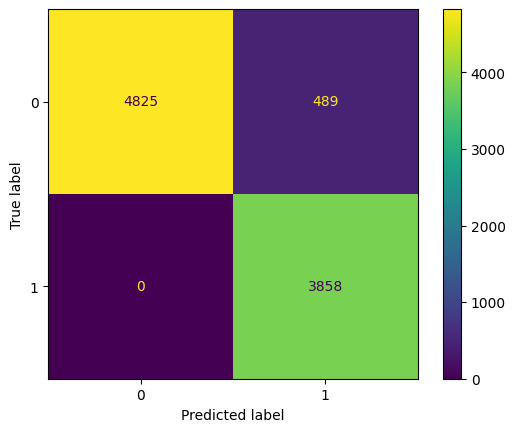


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5314
           1       0.89      1.00      0.94      3858

    accuracy                           0.95      9172
   macro avg       0.94      0.95      0.95      9172
weighted avg       0.95      0.95      0.95      9172


Accuracy: 94.66855647623201%
Precision: 88.75086266390613%
Recall: 100.0%


In [7]:
train_lg_classifier(BOW, np.asarray(corpus["CLASS"]))

/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best parameters set {'C': 100.0} with accuracy 0.9364513597355846

Confusion matrix:


/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


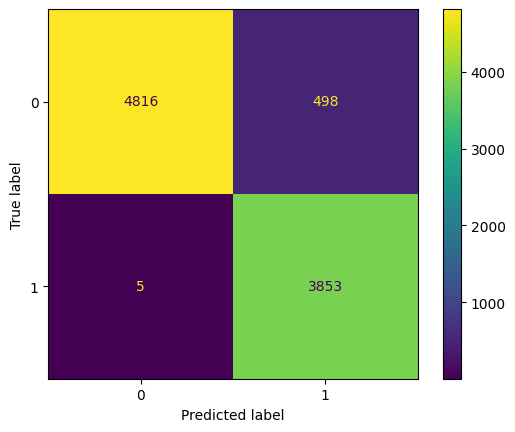


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5314
           1       0.89      1.00      0.94      3858

    accuracy                           0.95      9172
   macro avg       0.94      0.95      0.94      9172
weighted avg       0.95      0.95      0.95      9172


Accuracy: 94.51591801133887%
Precision: 88.55435532061595%
Recall: 99.87039917055469%


In [8]:
train_lg_classifier(BOW_2, np.asarray(corpus["CLASS"]))

/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best parameters set {'C': 1.0} with accuracy 0.9219196100133825

Confusion matrix:


/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


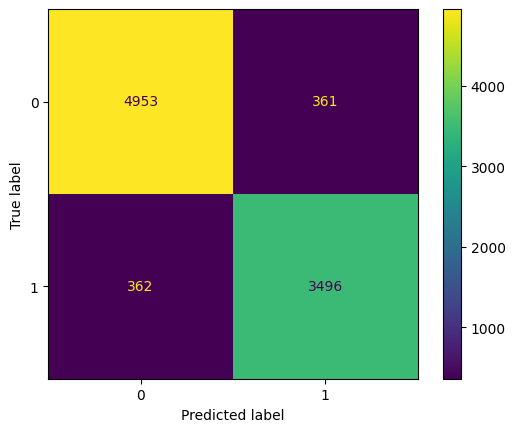


Classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5314
           1       0.91      0.91      0.91      3858

    accuracy                           0.92      9172
   macro avg       0.92      0.92      0.92      9172
weighted avg       0.92      0.92      0.92      9172


Accuracy: 92.11731356301787%
Precision: 90.64039408866995%
Recall: 90.61689994815967%


In [9]:
train_lg_classifier(BOW_3, np.asarray(corpus["CLASS"]))

/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best parameters set {'C': 10.0} with accuracy 0.9369653675117394

Confusion matrix:


/home/vivi/venv-idsta/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


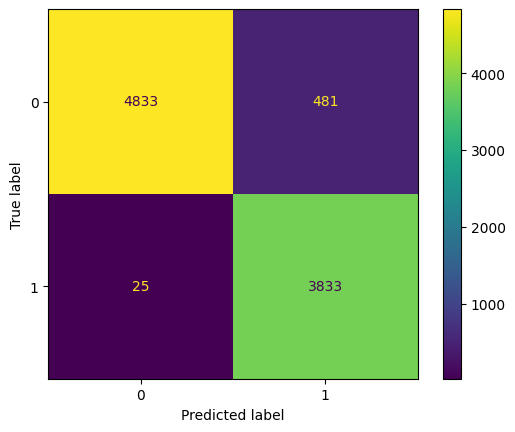


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5314
           1       0.89      0.99      0.94      3858

    accuracy                           0.94      9172
   macro avg       0.94      0.95      0.94      9172
weighted avg       0.95      0.94      0.95      9172


Accuracy: 94.48320976886176%
Precision: 88.85025498377375%
Recall: 99.35199585277346%


In [10]:
train_lg_classifier(tfidf_voc, np.asarray(corpus["CLASS"]))

### Load saved model

In [13]:
model_output_path = "saved_models/logisticregression_34-23.joblib"

def load_saved_model(model_path):
    return joblib.load(model_path)

In [14]:
clf = load_saved_model(model_output_path)
X_train, X_test, y_train, y_test = split_data(tfidf_voc, np.asarray(corpus["CLASS"]))

In [15]:
pd.DataFrame(clf.predict_proba(X_test[0]), columns=clf.classes_)

,0,1
0,0.00257,0.99743


In [16]:
pd.DataFrame(clf.predict_proba(X_test[100]), columns=clf.classes_)

,0,1
0,0.995293,0.004707
